# Action Conditional Deep Markov Model using cartpole dataset

In [1]:
from tqdm import tqdm

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from tensorboardX import SummaryWriter
import numpy as np

from utils import DMMDataset, imshow, postprocess
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


## データセットの準備
prepare_cartpole_dataset.pyを実行するか以下のリンクからデータセットをダウンロードしてください.  
https://drive.google.com/drive/folders/1w_97RLFS--CpdUCNw1C-3yPLhceZxkO2?usp=sharing

In [2]:
batch_size = 256
train_loader = DataLoader(DMMDataset(), batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(DMMTestDataset(), batch_size=batch_size, shuffle=False, drop_last=True)

_x = iter(train_loader).next()
print(_x['episode_frames'][0][0:30].shape)

torch.Size([30, 3, 28, 28])


torch.Size([30, 3, 28, 28])


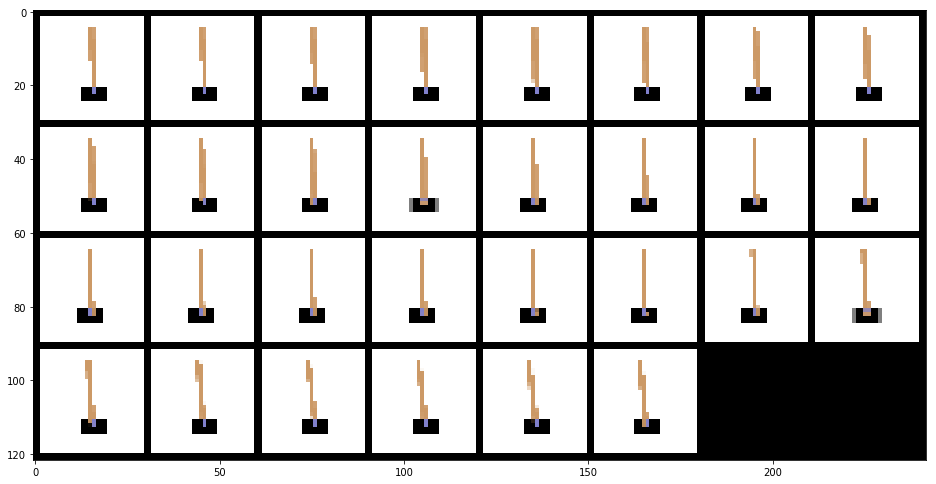

tensor([[0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [3]:
imshow(postprocess(_x['episode_frames'][0][0:30]))

# 0: Push cart to the left
# 1:Push cart to the right
print(_x['actions'][0][0:30])

# for more details about actions: https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/classic_control/cartpole.py#L37
# for more details about CartPole-v1: https://gym.openai.com/envs/CartPole-v1/

In [4]:
from pixyz.utils import print_latex
from pixyz.distributions import Bernoulli, Normal, Deterministic


h_dim = 32
hidden_dim = 32
z_dim = 16
t_max = 30
u_dim = 1

## Deep Markov Model
* 原著論文: Structured Inference Networks for Nonlinear State Space Models (https://arxiv.org/abs/1609.09869)
* 著者実装: https://github.com/clinicalml/dmm


Prior(Transition model): $p_{\theta}(z_{t} | z_{t-1}, u) =  \cal{N}(\mu = f_{prior_\mu}(z_{t-1}, u), \sigma^2 = f_{prior_\sigma^2}(z_{t-1}, u)$    
Generator(Emission): $p_{\theta}(x | z)=\mathscr{B}\left(x ; \lambda=g_{x}(z)\right)$  

RNN: $p(h) = RNN(x)$  
Inference(Combiner): $p_{\phi}(z | h, z_{t-1}, u) = \cal{N}(\mu = f_{\mu}(h, z_{t-1}, u), \sigma^2 = f_{\sigma^2}(h, z_{t-1}, u)$

## 確率分布の定義

In [5]:
# RNN
class RNN(Deterministic):
    """
    h = RNN(x)
    Given observed x, RNN output hidden state
    """
    def __init__(self):
        super(RNN, self).__init__(var=["h"], cond_var=["x"])
        
        # 28x28x3 → 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(128*7*7, 256)
        self.fc2 = nn.Linear(256, 32)
        
        self.rnn = nn.GRU(32, h_dim, bidirectional=True)
        self.h0 = nn.Parameter(torch.zeros(2, 1, self.rnn.hidden_size))
        self.hidden_size = self.rnn.hidden_size
        
    def forward(self, x):
        
        h0 = self.h0.expand(2, x.size(1), self.rnn.hidden_size).contiguous()
        x = x.reshape(-1, 3, 28, 28)      # Nx3x28x28

        h = F.relu(self.conv1(x))         # Nx64x14x14
        h = F.relu(self.conv2(h))         # Nx128x7x7
        h = h.view(h.shape[0], 128*7*7)   # Nx128*7*7
        h = F.relu(self.fc1(h))           # Nx256
        h = F.relu(self.fc2(h))           # Nx32
        h = h.reshape(30, -1, 32)         # 30x128x32

        h, _ = self.rnn(h, h0)            # 30x128x32, 1x128x32
        return {"h": h}


# Emission p(x_t | z_t)
class Generator(Normal):
    """
    Given the latent z at time step t, return the vector of
    probabilities that parameterizes the bernlulli distribution p(x_t | z_t)
    """
    def __init__(self):
        super(Generator, self).__init__(var=["x"], cond_var=["z"])
        self.fc1 = nn.Linear(z_dim, 256)
        self.fc2 = nn.Linear(256, 128*7*7)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)        

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = h.view(h.shape[0], 128, 7, 7) # 128*7*7
        h = F.relu(self.conv1(h))         # 64x14x14
        generated_x = self.conv2(h)                 # 3x28x28
        return {"loc": generated_x, "scale": 1.0}


class Inference(Normal):
    """
    given the latent z at time step t-1, the hidden state of the RNN h(x_{0:T} and u
    return the loc and scale vectors that
    parameterize the gaussian distribution q(z_t | z_{t-1}, x_{t:T}, u)
    """
    def __init__(self):
        super(Inference, self).__init__(var=["z"], cond_var=["h", "z_prev", "u"])
        self.fc1 = nn.Linear(z_dim+u_dim, h_dim*2)
        self.fc21 = nn.Linear(h_dim*2, z_dim)
        self.fc22 = nn.Linear(h_dim*2, z_dim)

        
    def forward(self, h, z_prev, u):
        feature = torch.cat((z_prev, u), 1)
        h_z = torch.tanh(self.fc1(feature))
        h = 0.5 * (h + h_z)
        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}


class Prior(Normal):
    """
    Given the latent variable at the time step t-1 and u,
    return the mean and scale vectors that parameterize the
    gaussian distribution p(z_t | z_{t-1}, u)
    """
    def __init__(self):
        super(Prior, self).__init__(var=["z"], cond_var=["z_prev", "u"])
        self.fc1 = nn.Linear(z_dim+u_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        
    def forward(self, z_prev, u):
        feature = torch.cat((z_prev, u), 1)
        h = F.relu(self.fc1(feature))
        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}

In [6]:
prior = Prior().to(device)
encoder = Inference().to(device)
decoder = Generator().to(device)
rnn = RNN().to(device)
generate_from_prior = prior * decoder

print_latex(generate_from_prior)

<IPython.core.display.Math object>

## ロス関数の定義

In [7]:
from pixyz.losses import KullbackLeibler
from pixyz.losses import Expectation as E
from pixyz.losses import LogProb
from pixyz.losses import IterativeLoss

step_loss = - E(encoder, LogProb(decoder)) + KullbackLeibler(encoder, prior)

# IterativeLoss: https://docs.pixyz.io/en/latest/losses.html#pixyz.losses.IterativeLoss
_loss = IterativeLoss(step_loss, max_iter=t_max, 
                      series_var=["x", "h", "u"], update_value={"z": "z_prev"})
loss = E(rnn, _loss).mean()

In [8]:
from pixyz.models import Model

dmm = Model(loss, distributions=[rnn, encoder, decoder, prior], 
            optimizer=optim.RMSprop, optimizer_params={"lr": 5e-4}, clip_grad_value=10)

print(dmm)
print_latex(dmm)

Distributions (for training): 
  p(h|x), p(z|h,z_{prev},u), p(x|z), p(z|z_{prev},u) 
Loss function: 
  mean \left(\mathbb{E}_{p(h|x)} \left[\sum_{t=1}^{30} \left(D_{KL} \left[p(z|h,z_{prev},u)||p(z|z_{prev},u) \right] - \mathbb{E}_{p(z|h,z_{prev},u)} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.0005
      momentum: 0
      weight_decay: 0
  )


<IPython.core.display.Math object>

## サンプリングの実装

In [9]:
def data_loop(epoch, loader, model, device, train_mode=False):
    mean_loss = 0
    for data in loader:
        x = data['episode_frames'].to(device) # 256,30,3,28,28
        u = data['actions'].to(device) # 256,30,1
        batch_size = x.size()[0]
        x = x.transpose(0, 1) # 30,256,3,28,28
        u = u.transpose(0, 1) # 30,256,1
        z_prev = torch.zeros(batch_size, z_dim).to(device)
        if train_mode:
            mean_loss += model.train({'x': x, 'z_prev': z_prev, 'u': u}).item() * batch_size
        else:
            mean_loss += model.test({'x': x, 'z_prev': z_prev, 'u': u}).item() * batch_size
    mean_loss /= len(loader.dataset)
    if train_mode:
        print('Epoch: {} Train loss: {:.4f}'.format(epoch, mean_loss))
    else:
        print('Test loss: {:.4f}'.format(mean_loss))
    return mean_loss

_data = iter(train_loader).next()
_u = _data['actions'].to(device) # 256,30,1
_u = _u.transpose(0, 1)          # 30,256,1

def plot_video_from_latent(batch_size):
    x = []
    z_prev = torch.zeros(batch_size, z_dim).to(device)
    for step in range(t_max):
        samples = generate_from_prior.sample({'z_prev': z_prev, 'u': _u[step]})
        x_t = decoder.sample_mean({"z": samples["z"]})
        z_prev = samples["z"]
        x.append(x_t[None, :])
    x = torch.cat(x, dim=0).transpose(0, 1)
    return x

## 学習

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 Train loss: 135122.8480


  0%|          | 1/200 [00:04<13:23,  4.04s/it]

Epoch: 2 Train loss: 90253.1320


  1%|          | 2/200 [00:07<13:04,  3.96s/it]

Epoch: 3 Train loss: 81096.6480


  2%|▏         | 3/200 [00:11<12:50,  3.91s/it]

Epoch: 4 Train loss: 77354.8600


  2%|▏         | 4/200 [00:15<12:38,  3.87s/it]

Epoch: 5 Train loss: 73845.1160


  2%|▎         | 5/200 [00:19<12:31,  3.85s/it]

Epoch: 6 Train loss: 72047.5200


  3%|▎         | 6/200 [00:23<12:25,  3.84s/it]

Epoch: 7 Train loss: 69970.8660


  4%|▎         | 7/200 [00:26<12:19,  3.83s/it]

Epoch: 8 Train loss: 69165.2320


  4%|▍         | 8/200 [00:30<12:14,  3.83s/it]

Epoch: 9 Train loss: 68189.1300


  4%|▍         | 9/200 [00:34<12:09,  3.82s/it]

Epoch: 10 Train loss: 67600.9240


  5%|▌         | 10/200 [00:38<12:04,  3.81s/it]

Epoch: 11 Train loss: 67195.2940


  6%|▌         | 11/200 [00:41<11:57,  3.80s/it]

Epoch: 12 Train loss: 66846.0460


  6%|▌         | 12/200 [00:45<11:52,  3.79s/it]

Epoch: 13 Train loss: 66366.1160


  6%|▋         | 13/200 [00:49<11:46,  3.78s/it]

Epoch: 14 Train loss: 66335.5240


  7%|▋         | 14/200 [00:52<11:41,  3.77s/it]

Epoch: 15 Train loss: 65877.7700


  8%|▊         | 15/200 [00:56<11:36,  3.77s/it]

Epoch: 16 Train loss: 65881.9380


  8%|▊         | 16/200 [01:00<11:31,  3.76s/it]

Epoch: 17 Train loss: 65479.0140


  8%|▊         | 17/200 [01:03<11:27,  3.75s/it]

Epoch: 18 Train loss: 65425.5420


  9%|▉         | 18/200 [01:07<11:22,  3.75s/it]

Epoch: 19 Train loss: 64886.0020


 10%|▉         | 19/200 [01:11<11:18,  3.75s/it]

Epoch: 20 Train loss: 64440.4860


 10%|█         | 20/200 [01:14<11:14,  3.75s/it]

Epoch: 21 Train loss: 63996.1900


 10%|█         | 21/200 [01:18<11:09,  3.74s/it]

Epoch: 22 Train loss: 63661.8600


 11%|█         | 22/200 [01:22<11:05,  3.74s/it]

Epoch: 23 Train loss: 63340.8840


 12%|█▏        | 23/200 [01:25<11:01,  3.74s/it]

Epoch: 24 Train loss: 63202.6720


 12%|█▏        | 24/200 [01:29<10:57,  3.74s/it]

Epoch: 25 Train loss: 62969.0240


 12%|█▎        | 25/200 [01:33<10:53,  3.74s/it]

Epoch: 26 Train loss: 62784.9000


 13%|█▎        | 26/200 [01:37<10:49,  3.73s/it]

Epoch: 27 Train loss: 62596.8000


 14%|█▎        | 27/200 [01:40<10:45,  3.73s/it]

Epoch: 28 Train loss: 62782.8880


 14%|█▍        | 28/200 [01:44<10:41,  3.73s/it]

Epoch: 29 Train loss: 62370.8600


 14%|█▍        | 29/200 [01:48<10:37,  3.73s/it]

Epoch: 30 Train loss: 62289.1480


 15%|█▌        | 30/200 [01:51<10:33,  3.73s/it]

Epoch: 31 Train loss: 61730.9880


 16%|█▌        | 31/200 [01:55<10:29,  3.73s/it]

Epoch: 32 Train loss: 60984.0500


 16%|█▌        | 32/200 [01:59<10:25,  3.73s/it]

Epoch: 33 Train loss: 60168.1780


 16%|█▋        | 33/200 [02:02<10:22,  3.73s/it]

Epoch: 34 Train loss: 59696.3000


 17%|█▋        | 34/200 [02:06<10:18,  3.73s/it]

Epoch: 35 Train loss: 59443.0800


 18%|█▊        | 35/200 [02:10<10:15,  3.73s/it]

Epoch: 36 Train loss: 59226.6440


 18%|█▊        | 36/200 [02:14<10:11,  3.73s/it]

Epoch: 37 Train loss: 58873.6280


 18%|█▊        | 37/200 [02:17<10:07,  3.72s/it]

Epoch: 38 Train loss: 58612.9920


 19%|█▉        | 38/200 [02:21<10:03,  3.72s/it]

Epoch: 39 Train loss: 58435.4760


 20%|█▉        | 39/200 [02:25<09:59,  3.72s/it]

Epoch: 40 Train loss: 58425.8340


 20%|██        | 40/200 [02:28<09:55,  3.72s/it]

Epoch: 41 Train loss: 58176.4440


 20%|██        | 41/200 [02:32<09:51,  3.72s/it]

Epoch: 42 Train loss: 58043.9400


 21%|██        | 42/200 [02:36<09:47,  3.72s/it]

Epoch: 43 Train loss: 57827.7780


 22%|██▏       | 43/200 [02:39<09:43,  3.72s/it]

Epoch: 44 Train loss: 57879.7720


 22%|██▏       | 44/200 [02:43<09:39,  3.71s/it]

Epoch: 45 Train loss: 57603.5380


 22%|██▎       | 45/200 [02:47<09:35,  3.71s/it]

Epoch: 46 Train loss: 57576.9940


 23%|██▎       | 46/200 [02:50<09:31,  3.71s/it]

Epoch: 47 Train loss: 57384.3040


 24%|██▎       | 47/200 [02:54<09:28,  3.71s/it]

Epoch: 48 Train loss: 57329.9740


 24%|██▍       | 48/200 [02:58<09:24,  3.71s/it]

Epoch: 49 Train loss: 57179.3520


 24%|██▍       | 49/200 [03:01<09:20,  3.71s/it]

Epoch: 50 Train loss: 57046.7380


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

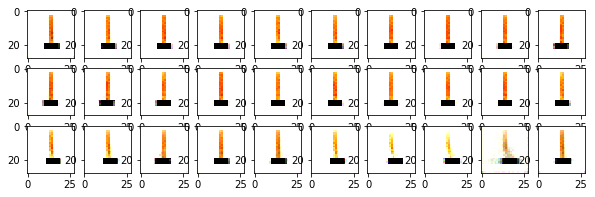

 25%|██▌       | 50/200 [03:07<09:21,  3.74s/it]

Epoch: 51 Train loss: 56918.8460


 26%|██▌       | 51/200 [03:10<09:17,  3.74s/it]

Epoch: 52 Train loss: 56915.1000


 26%|██▌       | 52/200 [03:14<09:14,  3.74s/it]

Epoch: 53 Train loss: 56753.4140


 26%|██▋       | 53/200 [03:18<09:10,  3.75s/it]

Epoch: 54 Train loss: 56730.8040


 27%|██▋       | 54/200 [03:22<09:06,  3.75s/it]

Epoch: 55 Train loss: 56547.8380


 28%|██▊       | 55/200 [03:26<09:03,  3.75s/it]

Epoch: 56 Train loss: 56521.4380


 28%|██▊       | 56/200 [03:29<08:59,  3.75s/it]

Epoch: 57 Train loss: 56354.7460


 28%|██▊       | 57/200 [03:33<08:56,  3.75s/it]

Epoch: 58 Train loss: 56339.7680


 29%|██▉       | 58/200 [03:37<08:52,  3.75s/it]

Epoch: 59 Train loss: 56202.9720


 30%|██▉       | 59/200 [03:41<08:48,  3.75s/it]

Epoch: 60 Train loss: 56237.3020


 30%|███       | 60/200 [03:44<08:44,  3.75s/it]

Epoch: 61 Train loss: 56139.1900


 30%|███       | 61/200 [03:48<08:41,  3.75s/it]

Epoch: 62 Train loss: 56147.0400


 31%|███       | 62/200 [03:52<08:37,  3.75s/it]

Epoch: 63 Train loss: 55940.0920


 32%|███▏      | 63/200 [03:56<08:33,  3.75s/it]

Epoch: 64 Train loss: 55937.6240


 32%|███▏      | 64/200 [04:00<08:30,  3.75s/it]

Epoch: 65 Train loss: 55873.2520


 32%|███▎      | 65/200 [04:03<08:26,  3.75s/it]

Epoch: 66 Train loss: 55850.3560


 33%|███▎      | 66/200 [04:07<08:22,  3.75s/it]

Epoch: 67 Train loss: 55750.4980


 34%|███▎      | 67/200 [04:11<08:18,  3.75s/it]

Epoch: 68 Train loss: 55680.4340


 34%|███▍      | 68/200 [04:15<08:15,  3.75s/it]

Epoch: 69 Train loss: 55597.4760


 34%|███▍      | 69/200 [04:18<08:11,  3.75s/it]

Epoch: 70 Train loss: 55611.5000


 35%|███▌      | 70/200 [04:22<08:07,  3.75s/it]

Epoch: 71 Train loss: 55472.8580


 36%|███▌      | 71/200 [04:26<08:04,  3.75s/it]

Epoch: 72 Train loss: 55479.3820


 36%|███▌      | 72/200 [04:30<08:00,  3.75s/it]

Epoch: 73 Train loss: 55377.1240


 36%|███▋      | 73/200 [04:33<07:56,  3.75s/it]

Epoch: 74 Train loss: 55396.5380


 37%|███▋      | 74/200 [04:37<07:52,  3.75s/it]

Epoch: 75 Train loss: 55280.8860


 38%|███▊      | 75/200 [04:41<07:48,  3.75s/it]

Epoch: 76 Train loss: 55321.7620


 38%|███▊      | 76/200 [04:45<07:45,  3.75s/it]

Epoch: 77 Train loss: 55240.7700


 38%|███▊      | 77/200 [04:48<07:41,  3.75s/it]

Epoch: 78 Train loss: 55269.5880


 39%|███▉      | 78/200 [04:52<07:37,  3.75s/it]

Epoch: 79 Train loss: 55133.5280


 40%|███▉      | 79/200 [04:56<07:33,  3.75s/it]

Epoch: 80 Train loss: 55104.4220


 40%|████      | 80/200 [05:00<07:30,  3.75s/it]

Epoch: 81 Train loss: 55081.1040


 40%|████      | 81/200 [05:03<07:26,  3.75s/it]

Epoch: 82 Train loss: 55047.0000


 41%|████      | 82/200 [05:07<07:22,  3.75s/it]

Epoch: 83 Train loss: 54985.2680


 42%|████▏     | 83/200 [05:11<07:19,  3.75s/it]

Epoch: 84 Train loss: 55013.6080


 42%|████▏     | 84/200 [05:15<07:15,  3.75s/it]

Epoch: 85 Train loss: 54898.4080


 42%|████▎     | 85/200 [05:19<07:11,  3.75s/it]

Epoch: 86 Train loss: 54905.5400


 43%|████▎     | 86/200 [05:22<07:07,  3.75s/it]

Epoch: 87 Train loss: 54800.7460


 44%|████▎     | 87/200 [05:26<07:04,  3.75s/it]

Epoch: 88 Train loss: 54869.8440


 44%|████▍     | 88/200 [05:30<07:00,  3.75s/it]

Epoch: 89 Train loss: 54773.8220


 44%|████▍     | 89/200 [05:34<06:56,  3.75s/it]

Epoch: 90 Train loss: 54797.5880


 45%|████▌     | 90/200 [05:37<06:52,  3.75s/it]

Epoch: 91 Train loss: 54722.7540


 46%|████▌     | 91/200 [05:41<06:49,  3.75s/it]

Epoch: 92 Train loss: 54689.5920


 46%|████▌     | 92/200 [05:45<06:45,  3.75s/it]

Epoch: 93 Train loss: 54673.8340


 46%|████▋     | 93/200 [05:49<06:41,  3.75s/it]

Epoch: 94 Train loss: 54688.9560


 47%|████▋     | 94/200 [05:52<06:38,  3.75s/it]

Epoch: 95 Train loss: 54589.7360


 48%|████▊     | 95/200 [05:56<06:34,  3.76s/it]

Epoch: 96 Train loss: 54670.2120


 48%|████▊     | 96/200 [06:00<06:30,  3.76s/it]

Epoch: 97 Train loss: 54538.6200


 48%|████▊     | 97/200 [06:04<06:26,  3.76s/it]

Epoch: 98 Train loss: 54601.9580


 49%|████▉     | 98/200 [06:08<06:23,  3.76s/it]

Epoch: 99 Train loss: 54493.3220


 50%|████▉     | 99/200 [06:11<06:19,  3.76s/it]

Epoch: 100 Train loss: 54537.6560


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

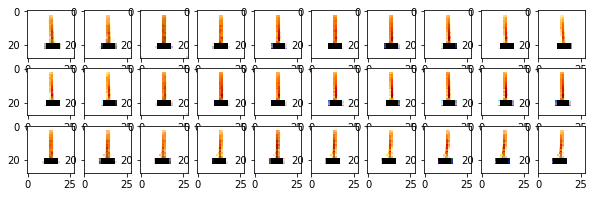

 50%|█████     | 100/200 [06:17<06:17,  3.77s/it]

Epoch: 101 Train loss: 54449.7640


 50%|█████     | 101/200 [06:20<06:13,  3.77s/it]

Epoch: 102 Train loss: 54469.0700


 51%|█████     | 102/200 [06:24<06:09,  3.77s/it]

Epoch: 103 Train loss: 54416.8460


 52%|█████▏    | 103/200 [06:28<06:05,  3.77s/it]

Epoch: 104 Train loss: 54398.1040


 52%|█████▏    | 104/200 [06:32<06:01,  3.77s/it]

Epoch: 105 Train loss: 54356.4000


 52%|█████▎    | 105/200 [06:35<05:58,  3.77s/it]

Epoch: 106 Train loss: 54385.8600


 53%|█████▎    | 106/200 [06:39<05:54,  3.77s/it]

Epoch: 107 Train loss: 54316.6400


 54%|█████▎    | 107/200 [06:43<05:50,  3.77s/it]

Epoch: 108 Train loss: 54326.4580


 54%|█████▍    | 108/200 [06:46<05:46,  3.77s/it]

Epoch: 109 Train loss: 54278.5520


 55%|█████▍    | 109/200 [06:50<05:42,  3.77s/it]

Epoch: 110 Train loss: 54270.9440


 55%|█████▌    | 110/200 [06:54<05:39,  3.77s/it]

Epoch: 111 Train loss: 54198.1240


 56%|█████▌    | 111/200 [06:58<05:35,  3.77s/it]

Epoch: 112 Train loss: 54217.6400


 56%|█████▌    | 112/200 [07:01<05:31,  3.77s/it]

Epoch: 113 Train loss: 54227.1020


 56%|█████▋    | 113/200 [07:05<05:27,  3.77s/it]

Epoch: 114 Train loss: 54192.6200


 57%|█████▋    | 114/200 [07:09<05:23,  3.77s/it]

Epoch: 115 Train loss: 54128.4960


 57%|█████▊    | 115/200 [07:12<05:19,  3.76s/it]

Epoch: 116 Train loss: 54140.9200


 58%|█████▊    | 116/200 [07:16<05:16,  3.76s/it]

Epoch: 117 Train loss: 54083.3540


 58%|█████▊    | 117/200 [07:20<05:12,  3.76s/it]

Epoch: 118 Train loss: 54150.9420


 59%|█████▉    | 118/200 [07:24<05:08,  3.76s/it]

Epoch: 119 Train loss: 54122.0900


 60%|█████▉    | 119/200 [07:27<05:04,  3.76s/it]

Epoch: 120 Train loss: 54080.4260


 60%|██████    | 120/200 [07:31<05:01,  3.76s/it]

Epoch: 121 Train loss: 54019.1040


 60%|██████    | 121/200 [07:35<04:57,  3.76s/it]

Epoch: 122 Train loss: 54062.8540


 61%|██████    | 122/200 [07:38<04:53,  3.76s/it]

Epoch: 123 Train loss: 54035.6220


 62%|██████▏   | 123/200 [07:42<04:49,  3.76s/it]

Epoch: 124 Train loss: 54011.5440


 62%|██████▏   | 124/200 [07:46<04:45,  3.76s/it]

Epoch: 125 Train loss: 54024.6200


 62%|██████▎   | 125/200 [07:50<04:42,  3.76s/it]

Epoch: 126 Train loss: 54015.2780


 63%|██████▎   | 126/200 [07:53<04:38,  3.76s/it]

Epoch: 127 Train loss: 53925.2420


 64%|██████▎   | 127/200 [07:57<04:34,  3.76s/it]

Epoch: 128 Train loss: 53923.9820


 64%|██████▍   | 128/200 [08:01<04:30,  3.76s/it]

Epoch: 129 Train loss: 53921.9400


 64%|██████▍   | 129/200 [08:05<04:27,  3.76s/it]

Epoch: 130 Train loss: 53954.9500


 65%|██████▌   | 130/200 [08:08<04:23,  3.76s/it]

Epoch: 131 Train loss: 53900.2320


 66%|██████▌   | 131/200 [08:12<04:19,  3.76s/it]

Epoch: 132 Train loss: 53951.0080


 66%|██████▌   | 132/200 [08:16<04:15,  3.76s/it]

Epoch: 133 Train loss: 53882.3460


 66%|██████▋   | 133/200 [08:19<04:11,  3.76s/it]

Epoch: 134 Train loss: 53892.5360


 67%|██████▋   | 134/200 [08:23<04:08,  3.76s/it]

Epoch: 135 Train loss: 53831.4800


 68%|██████▊   | 135/200 [08:27<04:04,  3.76s/it]

Epoch: 136 Train loss: 53867.3220


 68%|██████▊   | 136/200 [08:31<04:00,  3.76s/it]

Epoch: 137 Train loss: 53775.3900


 68%|██████▊   | 137/200 [08:34<03:56,  3.76s/it]

Epoch: 138 Train loss: 53849.3200


 69%|██████▉   | 138/200 [08:38<03:53,  3.76s/it]

Epoch: 139 Train loss: 53799.0400


 70%|██████▉   | 139/200 [08:42<03:49,  3.76s/it]

Epoch: 140 Train loss: 53831.0840


 70%|███████   | 140/200 [08:46<03:45,  3.76s/it]

Epoch: 141 Train loss: 53774.4560


 70%|███████   | 141/200 [08:49<03:41,  3.76s/it]

Epoch: 142 Train loss: 53768.7980


 71%|███████   | 142/200 [08:53<03:37,  3.76s/it]

Epoch: 143 Train loss: 53747.4720


 72%|███████▏  | 143/200 [08:57<03:34,  3.76s/it]

Epoch: 144 Train loss: 53760.9700


 72%|███████▏  | 144/200 [09:01<03:30,  3.76s/it]

Epoch: 145 Train loss: 53726.1320


 72%|███████▎  | 145/200 [09:04<03:26,  3.76s/it]

Epoch: 146 Train loss: 53704.6480


 73%|███████▎  | 146/200 [09:08<03:22,  3.76s/it]

Epoch: 147 Train loss: 53708.6720


 74%|███████▎  | 147/200 [09:12<03:19,  3.76s/it]

Epoch: 148 Train loss: 53695.1900


 74%|███████▍  | 148/200 [09:15<03:15,  3.76s/it]

Epoch: 149 Train loss: 53638.0920


 74%|███████▍  | 149/200 [09:19<03:11,  3.76s/it]

Epoch: 150 Train loss: 53633.9860


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

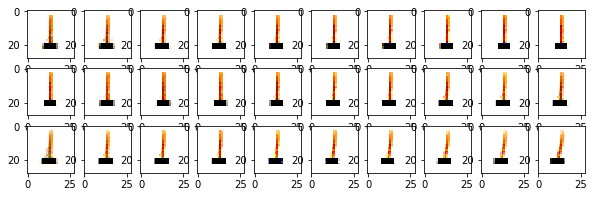

 75%|███████▌  | 150/200 [09:24<03:08,  3.76s/it]

Epoch: 151 Train loss: 53657.9560


 76%|███████▌  | 151/200 [09:28<03:04,  3.76s/it]

Epoch: 152 Train loss: 53670.0940


 76%|███████▌  | 152/200 [09:32<03:00,  3.76s/it]

Epoch: 153 Train loss: 53607.0760


 76%|███████▋  | 153/200 [09:35<02:56,  3.76s/it]

Epoch: 154 Train loss: 53651.3560


 77%|███████▋  | 154/200 [09:39<02:53,  3.76s/it]

Epoch: 155 Train loss: 53592.4700


 78%|███████▊  | 155/200 [09:43<02:49,  3.76s/it]

Epoch: 156 Train loss: 53585.4440


 78%|███████▊  | 156/200 [09:46<02:45,  3.76s/it]

Epoch: 157 Train loss: 53552.6640


 78%|███████▊  | 157/200 [09:50<02:41,  3.76s/it]

Epoch: 158 Train loss: 53611.3140


 79%|███████▉  | 158/200 [09:54<02:37,  3.76s/it]

Epoch: 159 Train loss: 53524.5080


 80%|███████▉  | 159/200 [09:58<02:34,  3.76s/it]

Epoch: 160 Train loss: 53590.1420


 80%|████████  | 160/200 [10:01<02:30,  3.76s/it]

Epoch: 161 Train loss: 53528.6480


 80%|████████  | 161/200 [10:05<02:26,  3.76s/it]

Epoch: 162 Train loss: 53558.7360


 81%|████████  | 162/200 [10:09<02:22,  3.76s/it]

Epoch: 163 Train loss: 53519.7460


 82%|████████▏ | 163/200 [10:12<02:19,  3.76s/it]

Epoch: 164 Train loss: 53528.5480


 82%|████████▏ | 164/200 [10:16<02:15,  3.76s/it]

Epoch: 165 Train loss: 53517.9280


 82%|████████▎ | 165/200 [10:20<02:11,  3.76s/it]

Epoch: 166 Train loss: 53496.1340


 83%|████████▎ | 166/200 [10:24<02:07,  3.76s/it]

Epoch: 167 Train loss: 53485.6460


 84%|████████▎ | 167/200 [10:27<02:04,  3.76s/it]

Epoch: 168 Train loss: 53502.5240


 84%|████████▍ | 168/200 [10:31<02:00,  3.76s/it]

Epoch: 169 Train loss: 53443.6100


 84%|████████▍ | 169/200 [10:35<01:56,  3.76s/it]

Epoch: 170 Train loss: 53506.9640


 85%|████████▌ | 170/200 [10:38<01:52,  3.76s/it]

Epoch: 171 Train loss: 53447.6360


 86%|████████▌ | 171/200 [10:42<01:48,  3.76s/it]

Epoch: 172 Train loss: 53448.5900


 86%|████████▌ | 172/200 [10:46<01:45,  3.76s/it]

Epoch: 173 Train loss: 53418.1960


 86%|████████▋ | 173/200 [10:49<01:41,  3.76s/it]

Epoch: 174 Train loss: 53440.3740


 87%|████████▋ | 174/200 [10:53<01:37,  3.76s/it]

Epoch: 175 Train loss: 53428.7820


 88%|████████▊ | 175/200 [10:57<01:33,  3.76s/it]

Epoch: 176 Train loss: 53430.0740


 88%|████████▊ | 176/200 [11:01<01:30,  3.76s/it]

Epoch: 177 Train loss: 53414.4660


 88%|████████▊ | 177/200 [11:04<01:26,  3.76s/it]

Epoch: 178 Train loss: 53422.6460


 89%|████████▉ | 178/200 [11:08<01:22,  3.76s/it]

Epoch: 179 Train loss: 53351.5180


 90%|████████▉ | 179/200 [11:12<01:18,  3.76s/it]

Epoch: 180 Train loss: 53396.0980


 90%|█████████ | 180/200 [11:15<01:15,  3.76s/it]

Epoch: 181 Train loss: 53367.9520


 90%|█████████ | 181/200 [11:19<01:11,  3.76s/it]

Epoch: 182 Train loss: 53406.4260


 91%|█████████ | 182/200 [11:23<01:07,  3.75s/it]

Epoch: 183 Train loss: 53343.4320


 92%|█████████▏| 183/200 [11:27<01:03,  3.75s/it]

Epoch: 184 Train loss: 53386.9000


 92%|█████████▏| 184/200 [11:30<01:00,  3.75s/it]

Epoch: 185 Train loss: 53286.1660


 92%|█████████▎| 185/200 [11:34<00:56,  3.75s/it]

Epoch: 186 Train loss: 53343.7720


 93%|█████████▎| 186/200 [11:38<00:52,  3.75s/it]

Epoch: 187 Train loss: 53285.4420


 94%|█████████▎| 187/200 [11:42<00:48,  3.75s/it]

Epoch: 188 Train loss: 53315.5800


 94%|█████████▍| 188/200 [11:45<00:45,  3.75s/it]

Epoch: 189 Train loss: 53277.0700


 94%|█████████▍| 189/200 [11:49<00:41,  3.75s/it]

Epoch: 190 Train loss: 53293.7760


 95%|█████████▌| 190/200 [11:53<00:37,  3.75s/it]

Epoch: 191 Train loss: 53241.2220


 96%|█████████▌| 191/200 [11:56<00:33,  3.75s/it]

Epoch: 192 Train loss: 53316.2600


 96%|█████████▌| 192/200 [12:00<00:30,  3.75s/it]

Epoch: 193 Train loss: 53282.9120


 96%|█████████▋| 193/200 [12:04<00:26,  3.75s/it]

Epoch: 194 Train loss: 53283.6220


 97%|█████████▋| 194/200 [12:08<00:22,  3.75s/it]

Epoch: 195 Train loss: 53215.3320


 98%|█████████▊| 195/200 [12:11<00:18,  3.75s/it]

Epoch: 196 Train loss: 53229.7160


 98%|█████████▊| 196/200 [12:15<00:15,  3.75s/it]

Epoch: 197 Train loss: 53230.3920


 98%|█████████▊| 197/200 [12:19<00:11,  3.75s/it]

Epoch: 198 Train loss: 53257.9480


 99%|█████████▉| 198/200 [12:23<00:07,  3.75s/it]

Epoch: 199 Train loss: 53196.7220


100%|█████████▉| 199/200 [12:26<00:03,  3.75s/it]

Epoch: 200 Train loss: 53217.5220


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

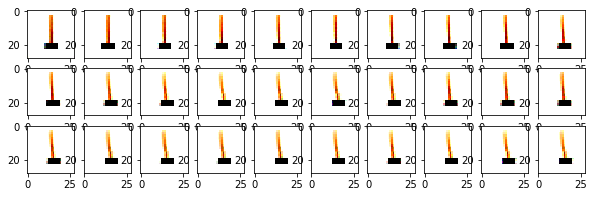

100%|██████████| 200/200 [12:32<00:00,  3.76s/it]


In [10]:
epochs = 200
for epoch in tqdm(range(1, epochs + 1)):
    train_loss = data_loop(epoch, train_loader, dmm, device, train_mode=True)
    sample = plot_video_from_latent(batch_size)
    if epoch % 50 == 0:
        plt.figure(figsize=(10,3))
        for i in range(30):
            plt.subplot(3,10,i+1)
            plt.imshow(sample[0][i].cpu().detach().numpy().astype(np.float).reshape(3,28,28).transpose(1,2,0))
        plt.show()

torch.Size([30, 3, 28, 28])


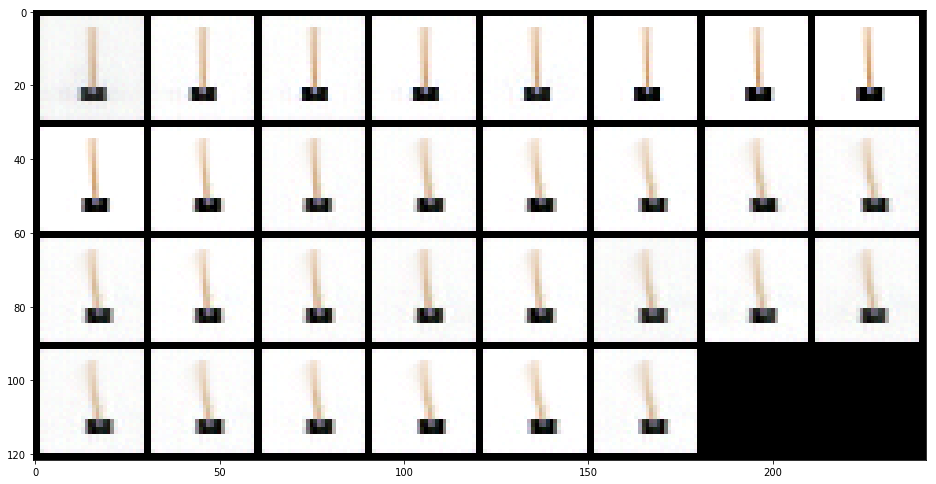

In [11]:
imshow(postprocess(sample[0].cpu().detach()))

torch.Size([30, 3, 28, 28])


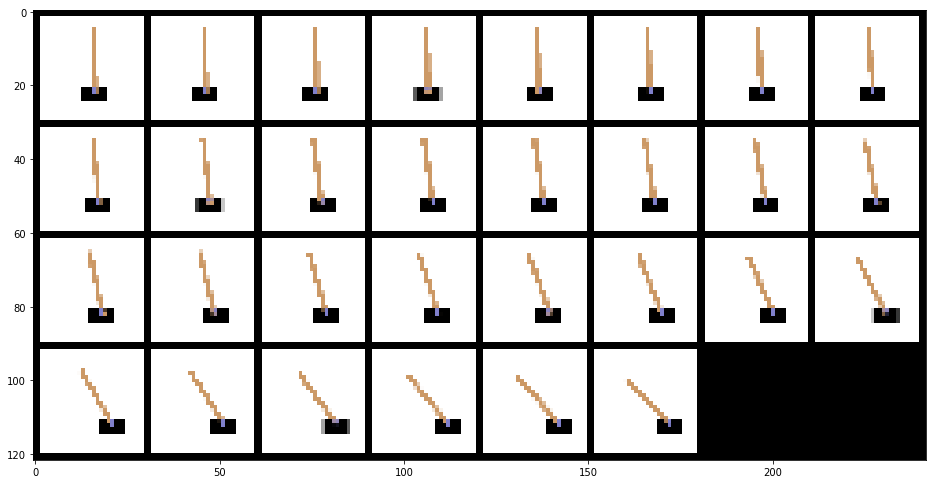

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]])


In [12]:
imshow(postprocess(_data["episode_frames"][0]))
print(_data["actions"][0])